In [ ]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pprint import pprint
import os.path as pth

import gzip
import pickle

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Flatten, Reshape
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split, KFold, GroupKFold

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
ROOT_DIR = '../data'
TRAIN_IMG_DIR = pth.join(ROOT_DIR, 'original/train_images')
TRAIN_DATA_DIR = ROOT_DIR

WIDTH=1600
HEIGHT=256

In [ ]:
data = pd.read_feather(pth.join(TRAIN_DATA_DIR, 'train.feather'))

In [ ]:
image_groups = data.groupby('imageid')

s = image_groups[['mask_present']].sum().mask_present
s.name = 'nmasks'
data = data.merge(s, left_on=['imageid'], right_index=True)

In [ ]:
data.head()

In [ ]:
with gzip.open(pth.join(TRAIN_DATA_DIR, 'train_masks.pickle.gz'), 'rb') as f:
    image_masks = pickle.load(f)

from loaders import BlockwiseImageLoader
n = 4
b = BlockwiseImageLoader(train_cv_image_names[0:10], image_groups, image_masks, n, 128, 64)
img_patches, mask_patches = b[0]
imgs = b.combine_patches(img_patches)

for i in range(n):
    name = train_cv_image_names[i]
    im = plt.imread(pth.join(TRAIN_IMG_DIR, f'{name}.jpg')).astype('float32')[:, :, 0]
    plt.figure()
    plt.imshow(im, cmap='gray')
    plt.show()
    plt.figure()
    plt.imshow(imgs[i], cmap='gray')
    plt.show()


In [234]:
from models import SimpleAE, SimpleInception

model = SimpleAE(64)
model.build_model()
model.summary()

Model: "model_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           [(None, 256, 1600, 1 0                                            
__________________________________________________________________________________________________
conv2d_1046 (Conv2D)            (None, 256, 1600, 16 800         input_60[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_165 (MaxPooling2D (None, 64, 800, 16)  0           conv2d_1046[0][0]                
__________________________________________________________________________________________________
conv2d_1047 (Conv2D)            (None, 64, 800, 64)  25664       max_pooling2d_165[0][0]          
___________________________________________________________________________________________

In [235]:
image_names = list(data[data.nmasks > 0].imageid.unique())[0:1000]
train_cv_image_names, test_image_names = train_test_split(image_names)
len(train_cv_image_names), len(test_image_names)

(750, 250)

In [236]:
from loaders import ImageLoader, BlockwiseImageLoader

BATCH_SIZE = 4
PATCH_SIZE = 64
PATCH_STRIDE = 32

kfold = KFold(2)

for train_indices, cv_indices in kfold.split(train_cv_image_names):
    train_image_names = [train_cv_image_names[i] for i in train_indices]
    cv_image_names = [train_cv_image_names[i] for i in cv_indices]
    print(f'{len(train_image_names)} training samples, {len(cv_image_names)} validation samples')
    model.fit_generator(
        generator=ImageLoader(train_image_names, image_groups, image_masks, 
                              BATCH_SIZE),#, PATCH_SIZE, PATCH_STRIDE),
        validation_data=ImageLoader(cv_image_names, image_groups, image_masks, 
                                    BATCH_SIZE),#, PATCH_SIZE, PATCH_STRIDE),
        epochs=5)

375 training samples, 375 validation samples
Epoch 1/5
94/94 [==============================] - 51s 539ms/step - loss: 0.4366 - conv2d_1052_loss: 0.0485 - conv2d_1056_loss: 0.0292 - conv2d_1060_loss: 0.2430 - conv2d_1064_loss: 0.1159 - val_loss: 0.2631 - val_conv2d_1052_loss: 0.0120 - val_conv2d_1056_loss: 0.0045 - val_conv2d_1060_loss: 0.1931 - val_conv2d_1064_loss: 0.0535
Epoch 2/5
94/94 [==============================] - 37s 398ms/step - loss: 0.2812 - conv2d_1052_loss: 0.0149 - conv2d_1056_loss: 0.0048 - conv2d_1060_loss: 0.1905 - conv2d_1064_loss: 0.0710 - val_loss: 0.2563 - val_conv2d_1052_loss: 0.0128 - val_conv2d_1056_loss: 0.0045 - val_conv2d_1060_loss: 0.1858 - val_conv2d_1064_loss: 0.0532
Epoch 3/5
94/94 [==============================] - 38s 403ms/step - loss: 0.2425 - conv2d_1052_loss: 0.0132 - conv2d_1056_loss: 0.0043 - conv2d_1060_loss: 0.1648 - conv2d_1064_loss: 0.0601 - val_loss: 0.2236 - val_conv2d_1052_loss: 0.0108 - val_conv2d_1056_loss: 0.0036 - val_conv2d_1060_los

In [237]:
model.model.history.history.keys()

dict_keys(['loss', 'conv2d_1052_loss', 'conv2d_1056_loss', 'conv2d_1060_loss', 'conv2d_1064_loss', 'val_loss', 'val_conv2d_1052_loss', 'val_conv2d_1056_loss', 'val_conv2d_1060_loss', 'val_conv2d_1064_loss'])

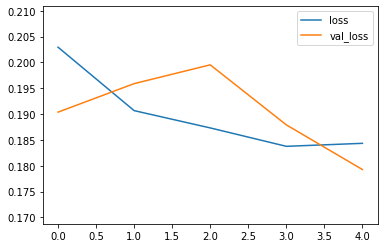

In [238]:
def plot_history(history, keys=['loss', 'val_loss']):
    if len(keys) == 0:
        return
    
    n = 3
    primary = np.array(history[keys[0]])
    ymin = primary.mean() - primary.std() * n
    ymax = primary.mean() + primary.std() * n
    
    plt.figure()
    plt.ylim(ymin, ymax)
    for key in keys:
        if key in history.keys():
            #plt.plot(np.arange(len(history[key])), history[key], label=key)
            plt.plot(history[key], label=key)
        else:
            print(f'Unable to plot {key}')
    plt.legend()
    plt.show()
    
plot_history(model.model.history.history)
    

In [239]:
names = test_image_names[0:10]
loader = ImageLoader(names, image_groups, image_masks,
                     BATCH_SIZE)#, PATCH_SIZE, PATCH_STRIDE)
results = model.predict_generator(generator=loader)
#results = loader.combine_mask_patches(results)

105f93d9e


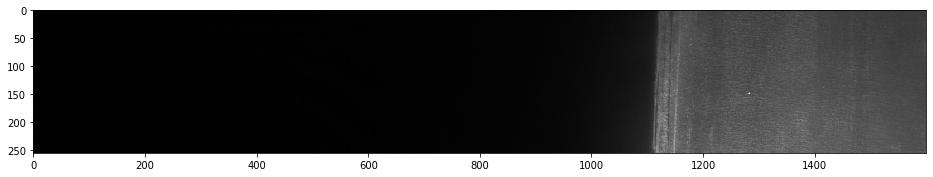

105f93d9e 1 REF


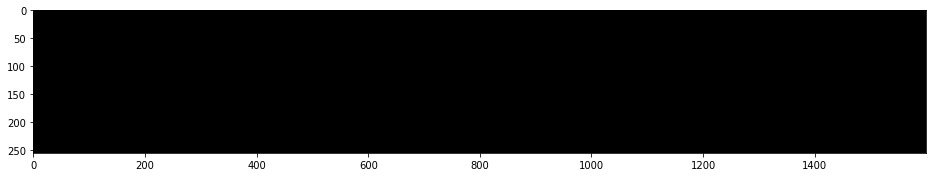

105f93d9e 1 TEST 130601


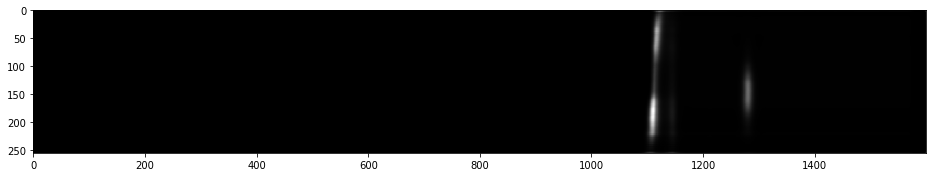

105f93d9e 2 REF


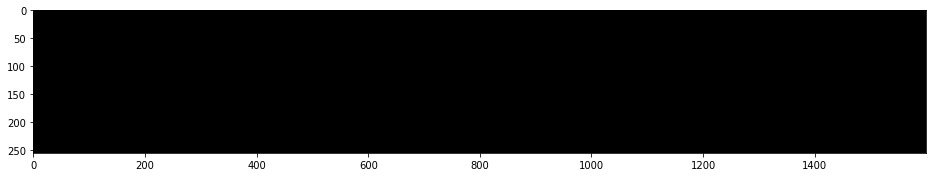

105f93d9e 2 TEST 126643


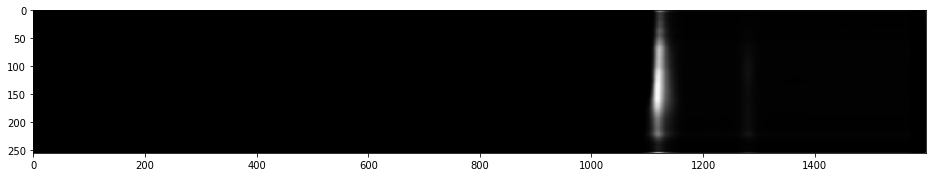

105f93d9e 3 REF


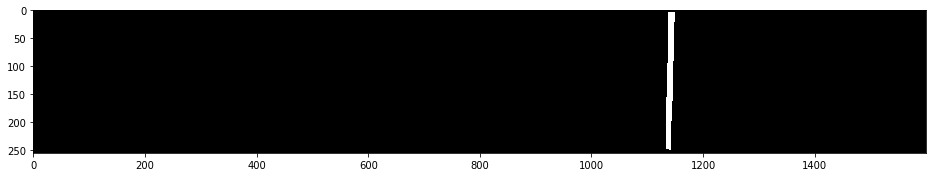

105f93d9e 3 TEST 139250


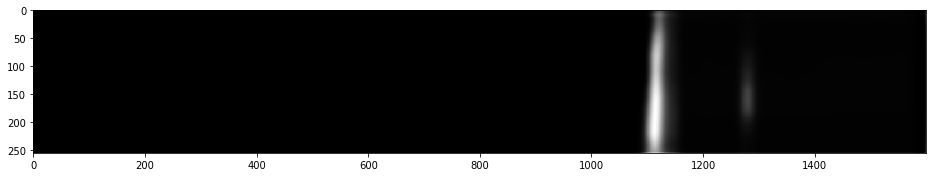

105f93d9e 4 REF


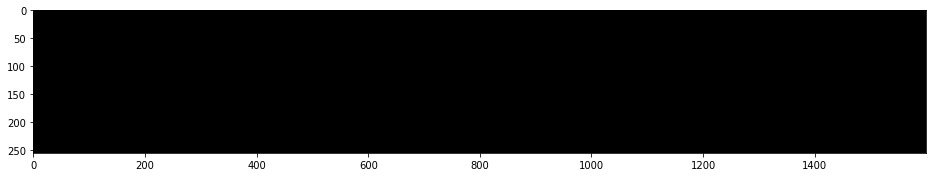

105f93d9e 4 TEST 132401


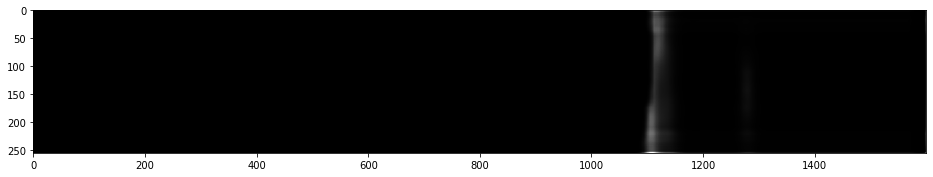

0a37f0a29


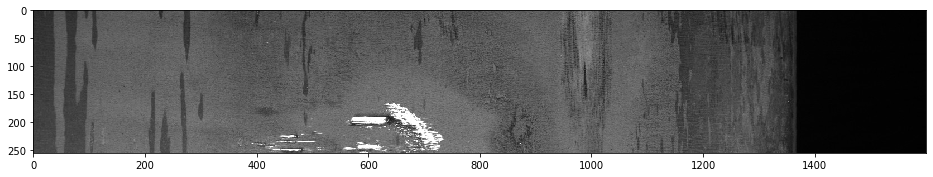

0a37f0a29 1 REF


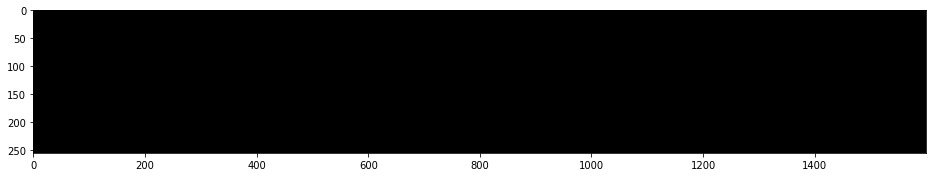

0a37f0a29 1 TEST 346678


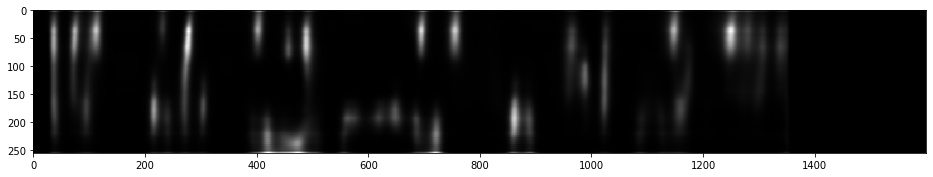

0a37f0a29 2 REF


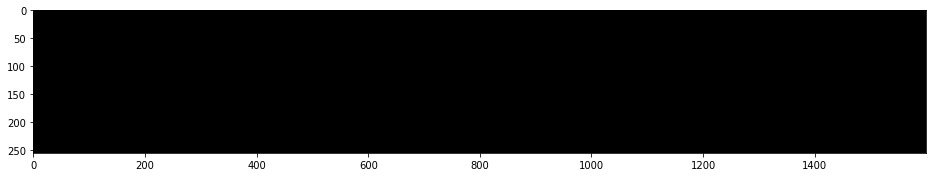

0a37f0a29 2 TEST 342551


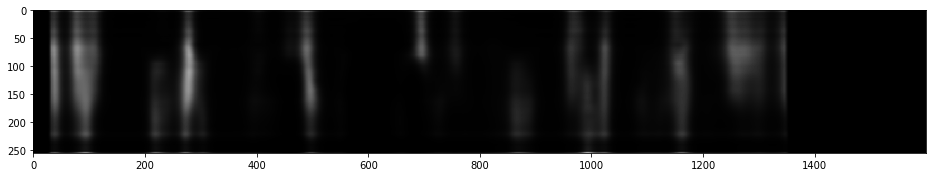

0a37f0a29 3 REF


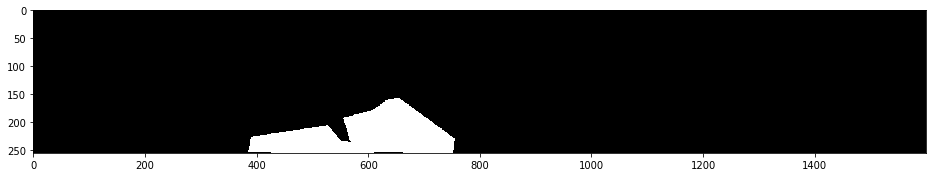

0a37f0a29 3 TEST 350445


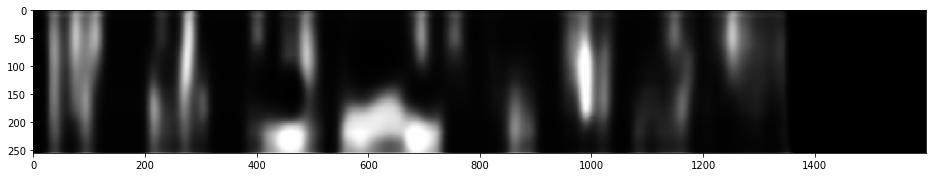

0a37f0a29 4 REF


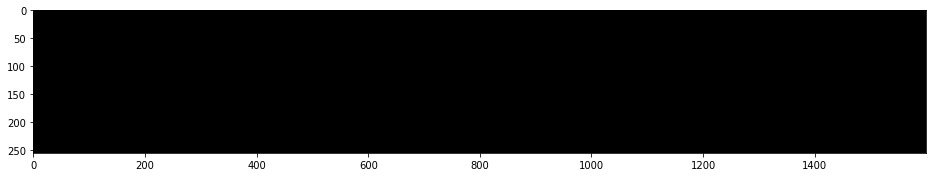

0a37f0a29 4 TEST 346361


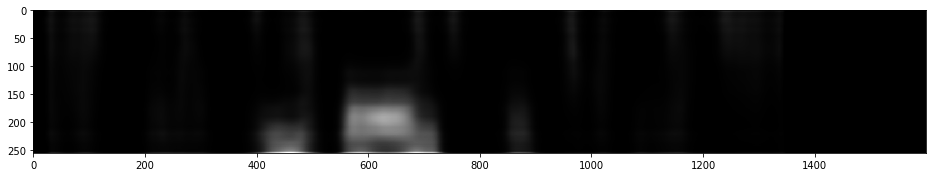

112d183e5


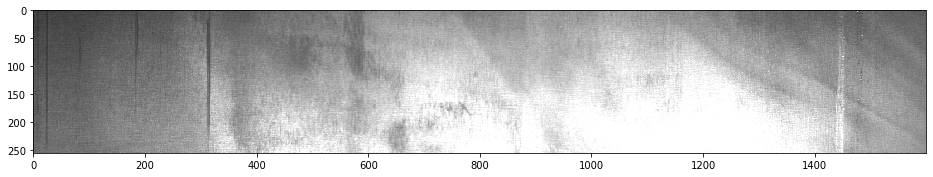

112d183e5 1 REF


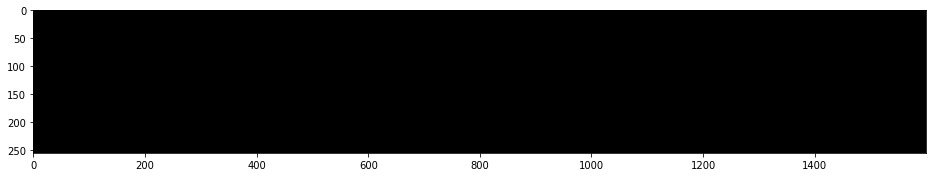

112d183e5 1 TEST 402781


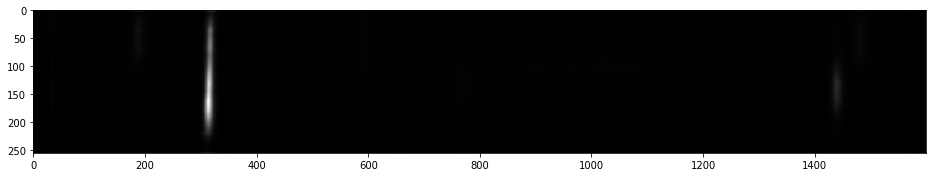

112d183e5 2 REF


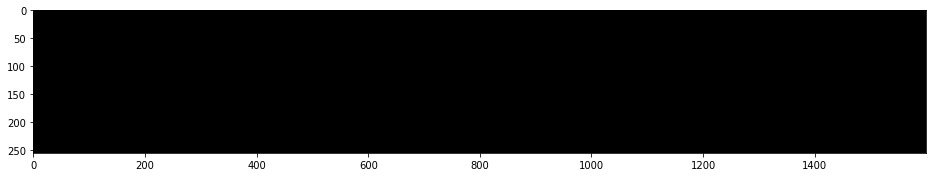

112d183e5 2 TEST 398527


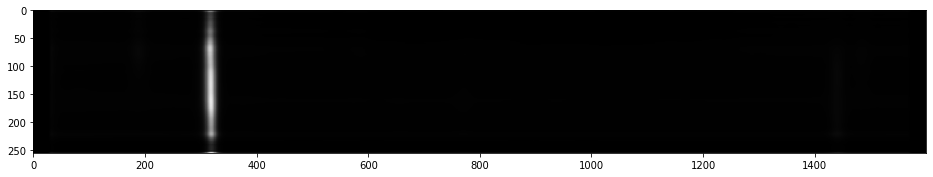

112d183e5 3 REF


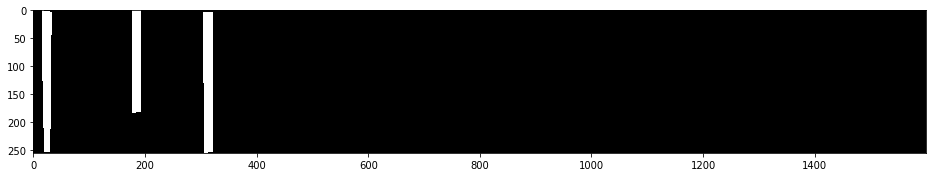

112d183e5 3 TEST 409600


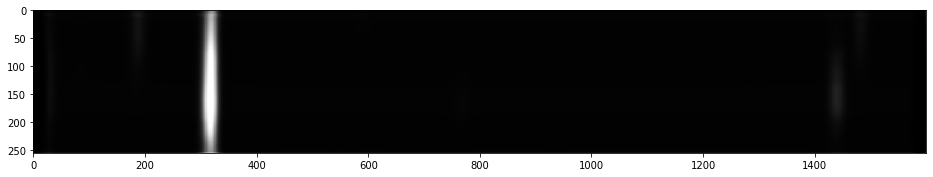

112d183e5 4 REF


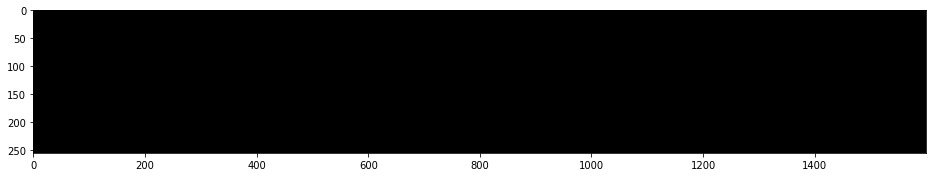

112d183e5 4 TEST 407630


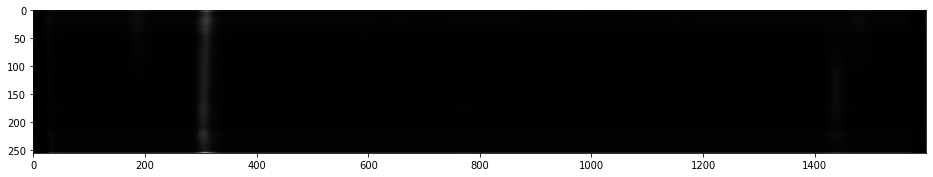

190190a6f


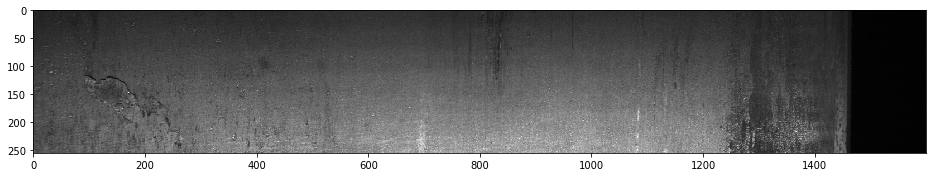

190190a6f 1 REF


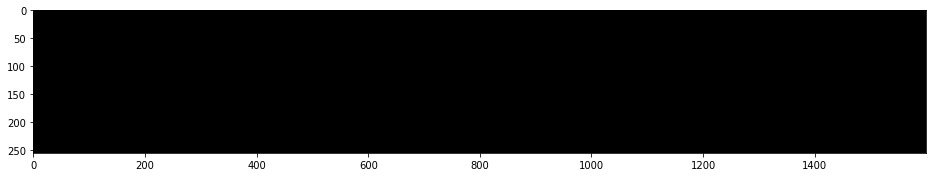

190190a6f 1 TEST 370739


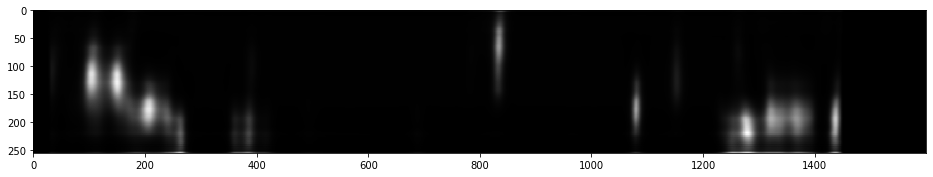

190190a6f 2 REF


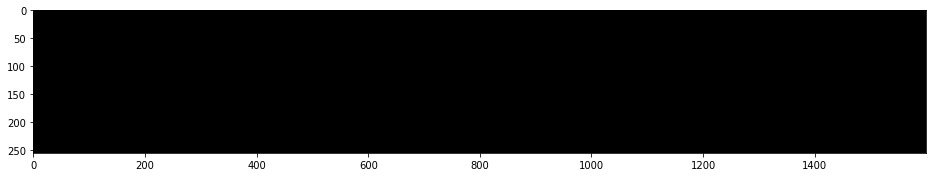

190190a6f 2 TEST 366656


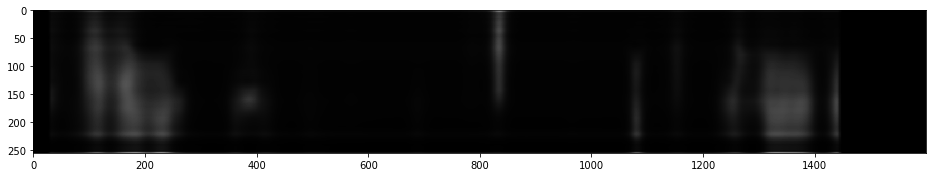

190190a6f 3 REF


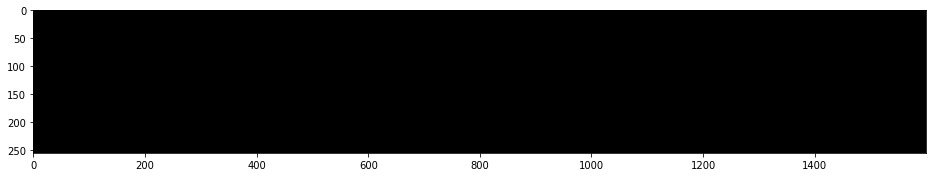

190190a6f 3 TEST 374589


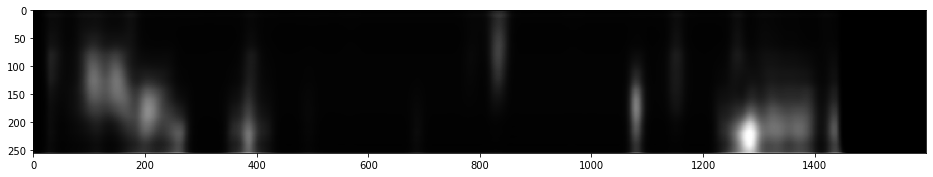

190190a6f 4 REF


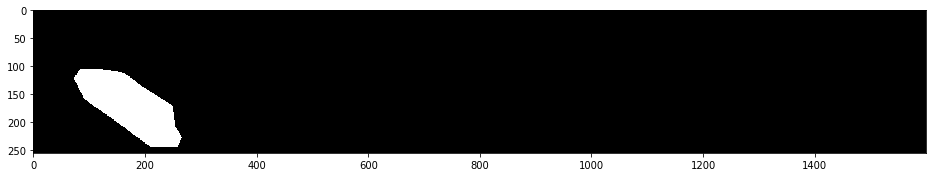

190190a6f 4 TEST 370599


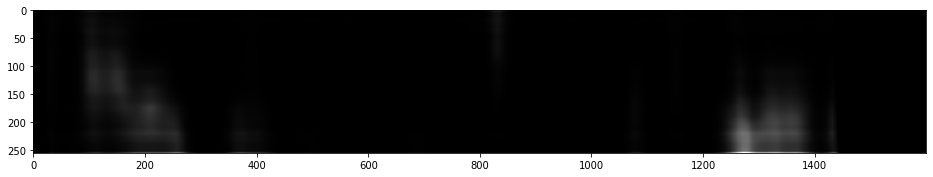

0f4a022fd


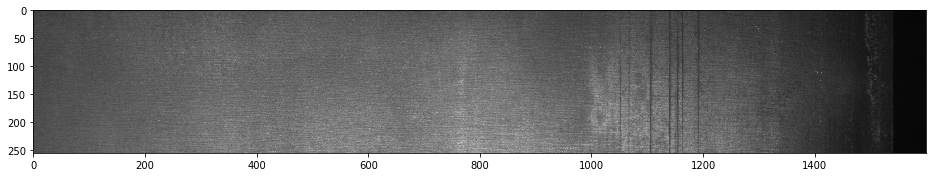

0f4a022fd 1 REF


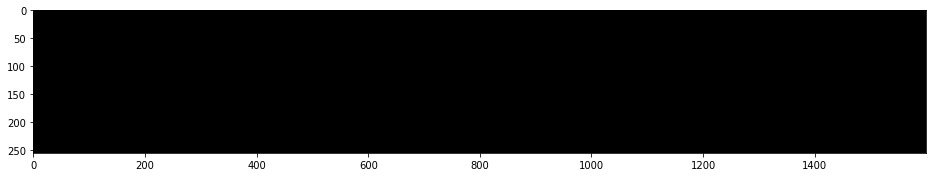

0f4a022fd 1 TEST 390164


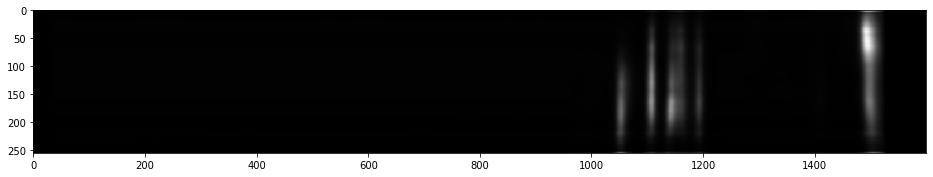

0f4a022fd 2 REF


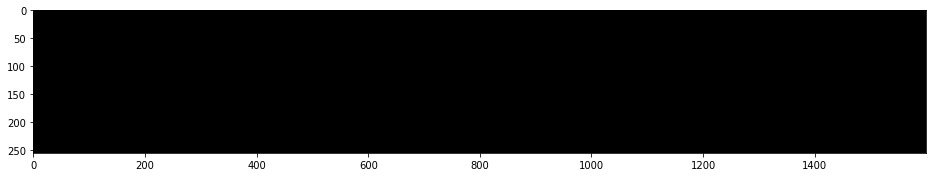

0f4a022fd 2 TEST 386081


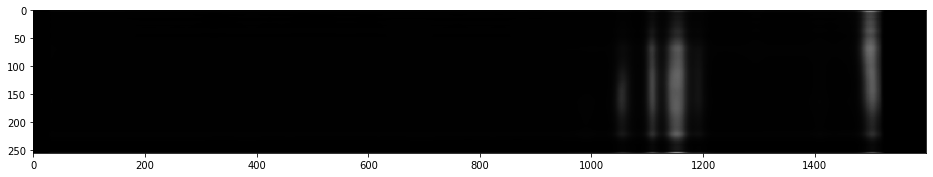

0f4a022fd 3 REF


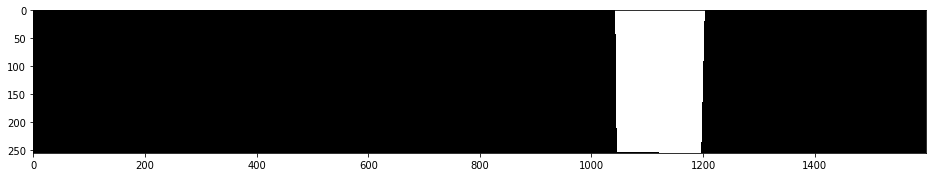

0f4a022fd 3 TEST 395166


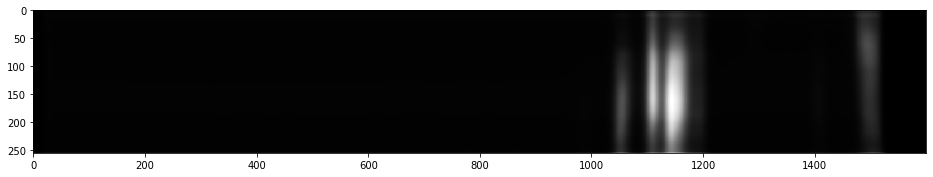

0f4a022fd 4 REF


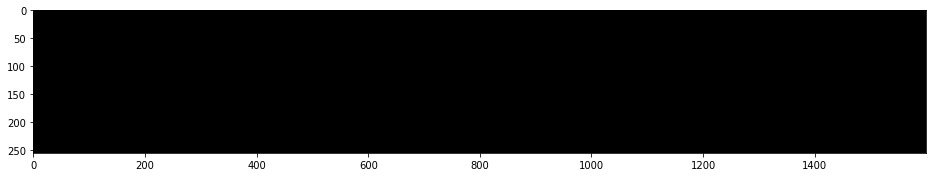

0f4a022fd 4 TEST 390569


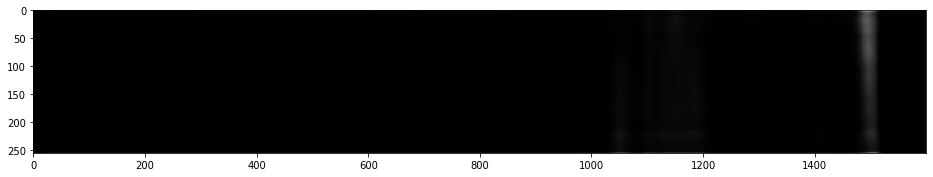

10d98c2be


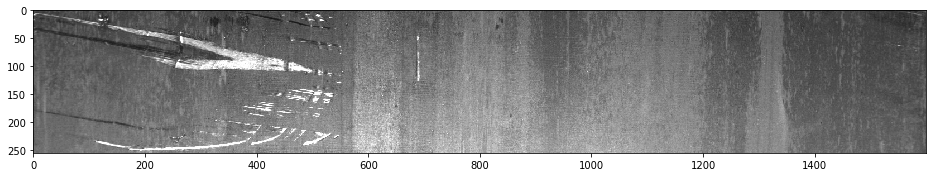

10d98c2be 1 REF


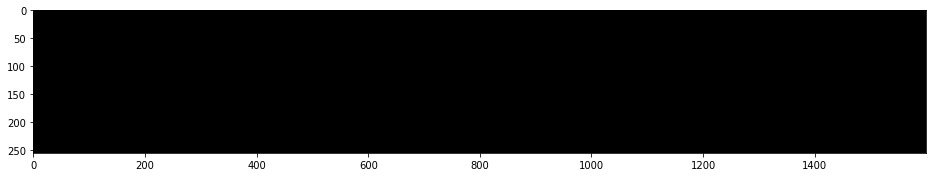

10d98c2be 1 TEST 404165


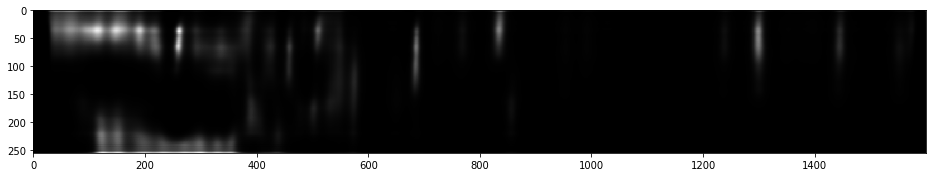

10d98c2be 2 REF


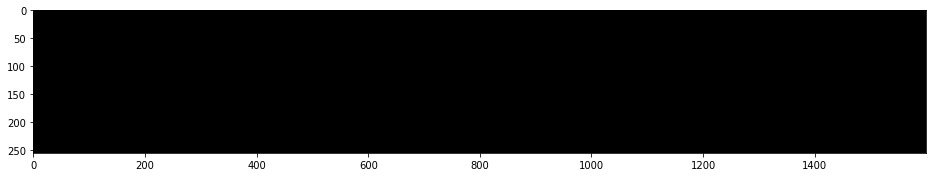

10d98c2be 2 TEST 399898


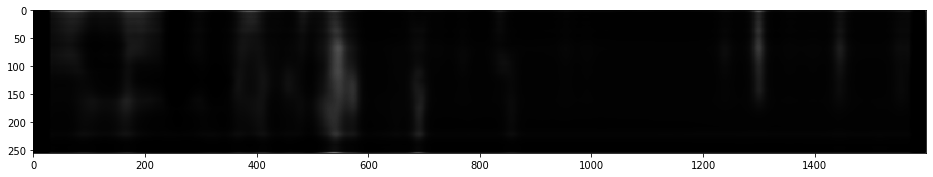

10d98c2be 3 REF


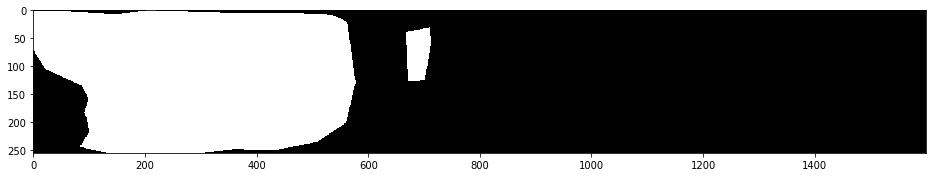

10d98c2be 3 TEST 409600


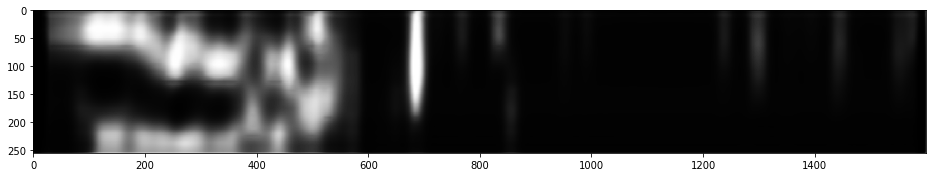

10d98c2be 4 REF


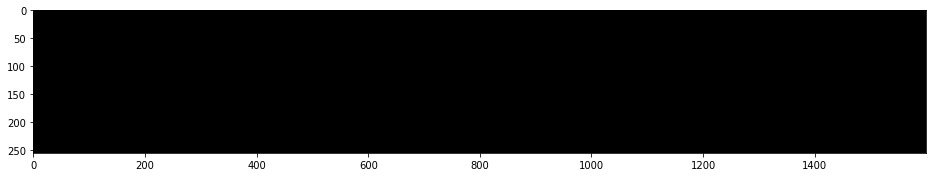

10d98c2be 4 TEST 408942


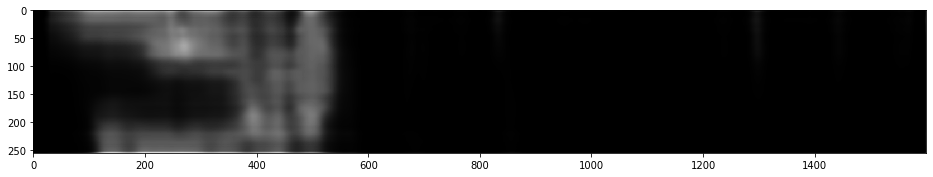

04055fd3e


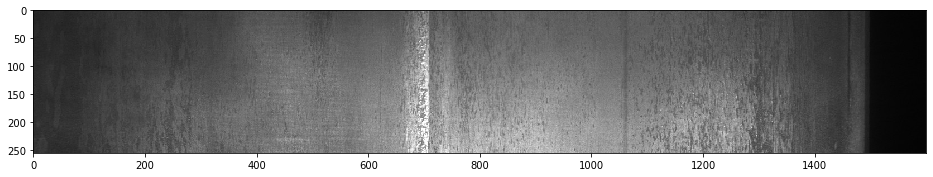

04055fd3e 1 REF


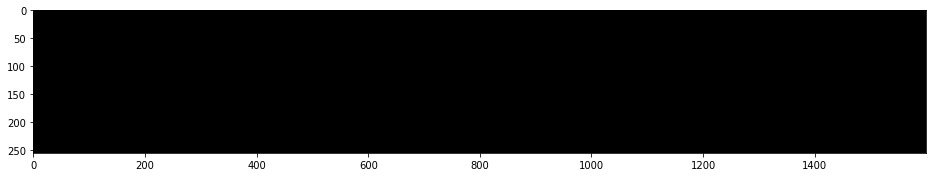

04055fd3e 1 TEST 381693


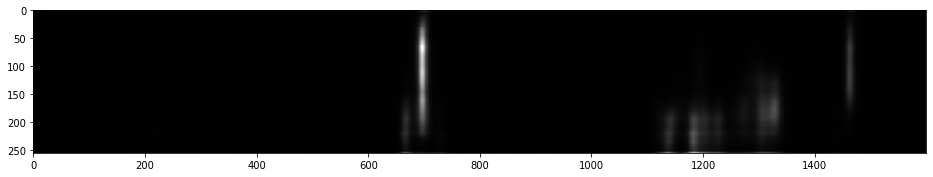

04055fd3e 2 REF


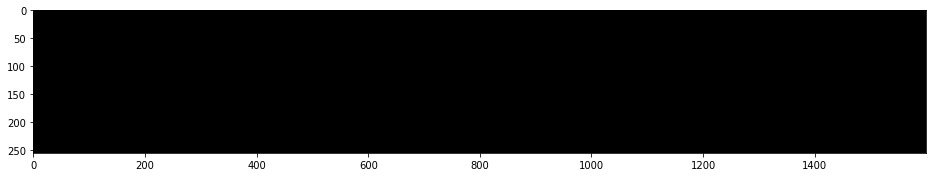

04055fd3e 2 TEST 376669


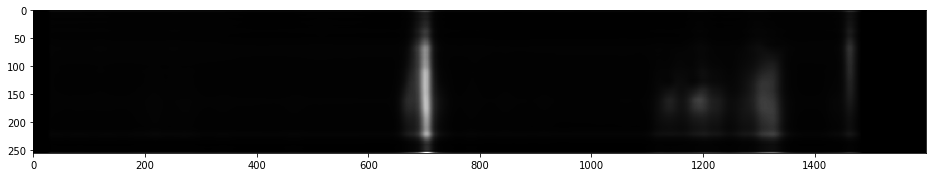

04055fd3e 3 REF


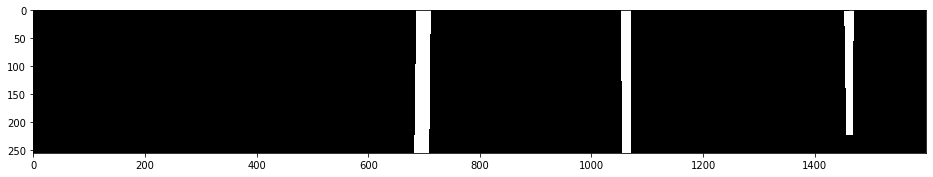

04055fd3e 3 TEST 384424


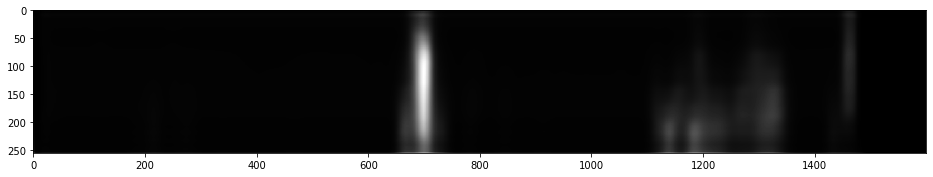

04055fd3e 4 REF


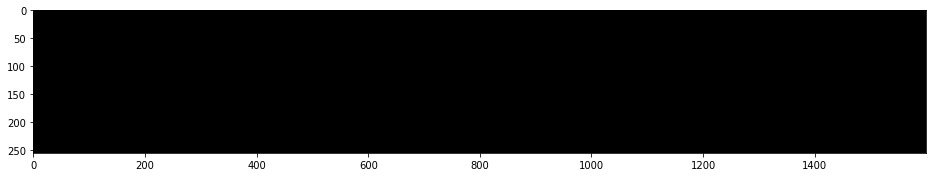

04055fd3e 4 TEST 379950


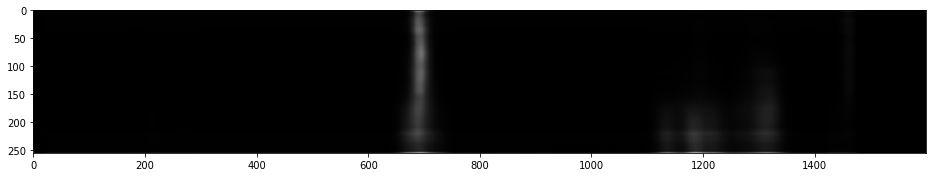

249f9dfdd


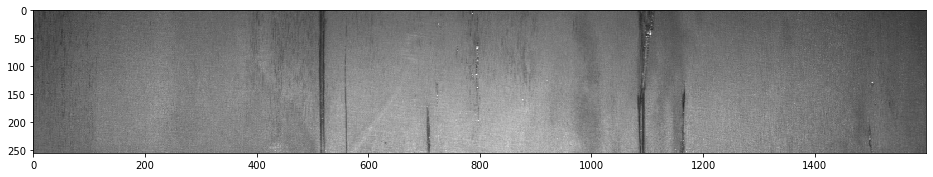

249f9dfdd 1 REF


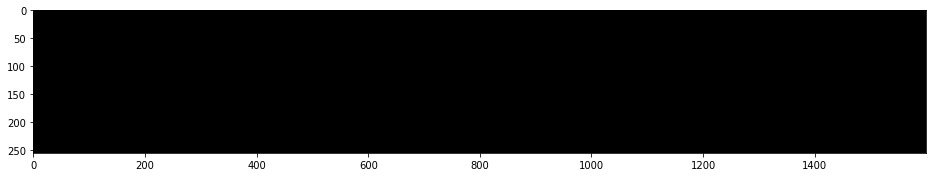

249f9dfdd 1 TEST 404264


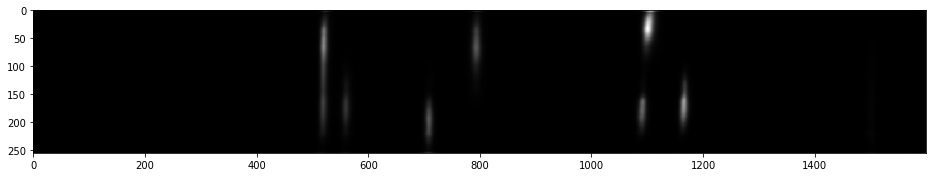

249f9dfdd 2 REF


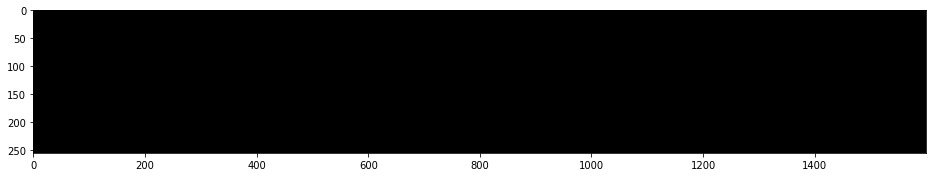

249f9dfdd 2 TEST 399824


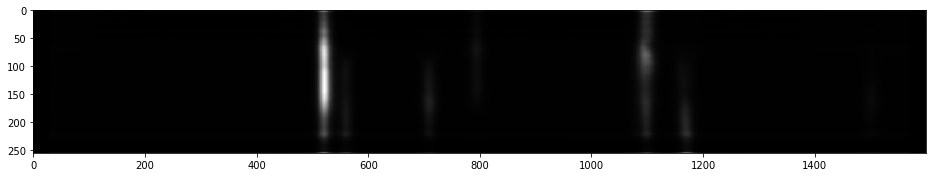

249f9dfdd 3 REF


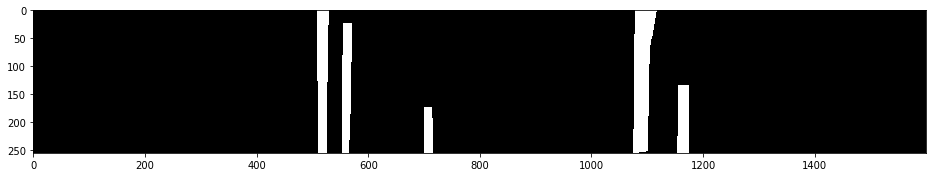

249f9dfdd 3 TEST 409600


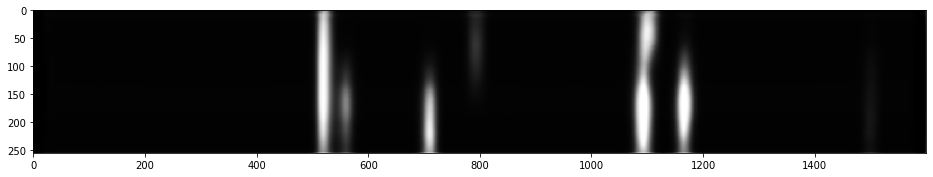

249f9dfdd 4 REF


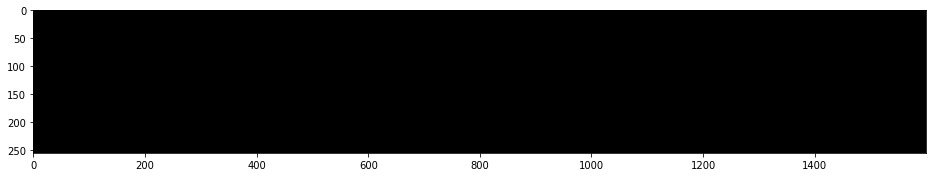

249f9dfdd 4 TEST 409218


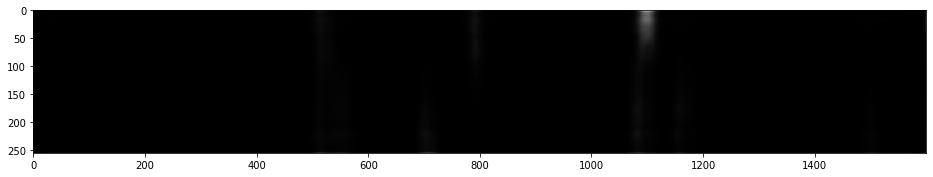

207f33325


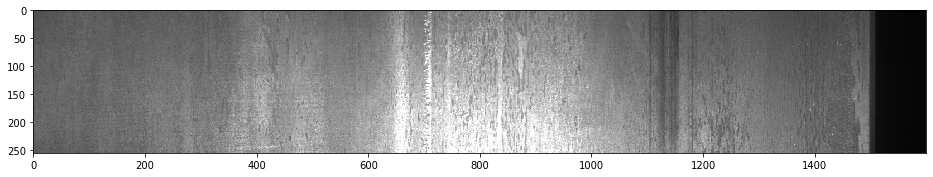

207f33325 1 REF


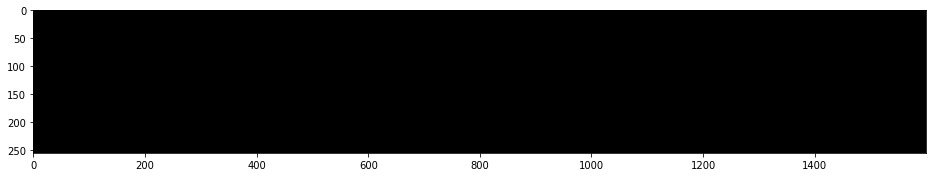

207f33325 1 TEST 381911


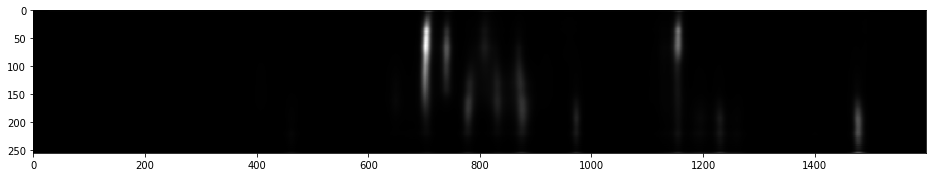

207f33325 2 REF


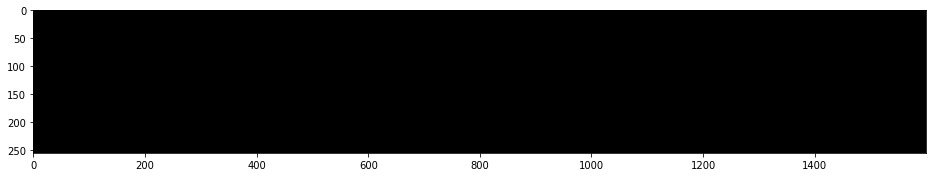

207f33325 2 TEST 378334


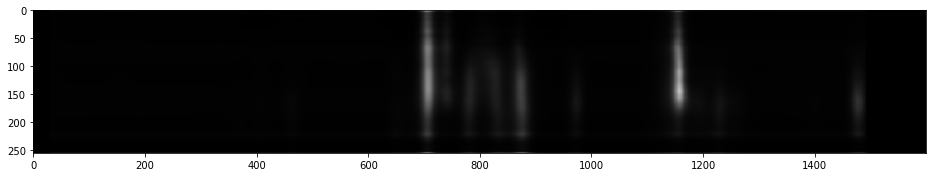

207f33325 3 REF


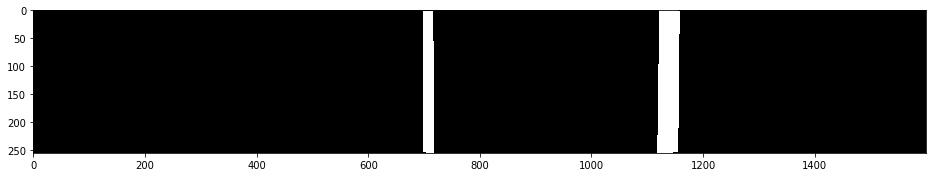

207f33325 3 TEST 387928


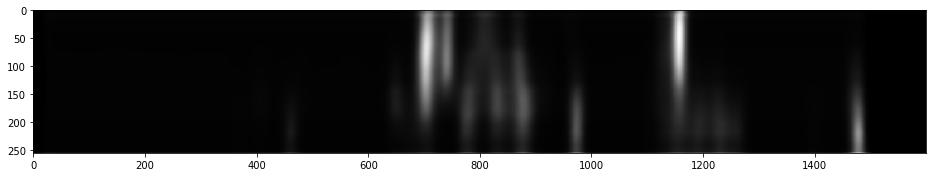

207f33325 4 REF


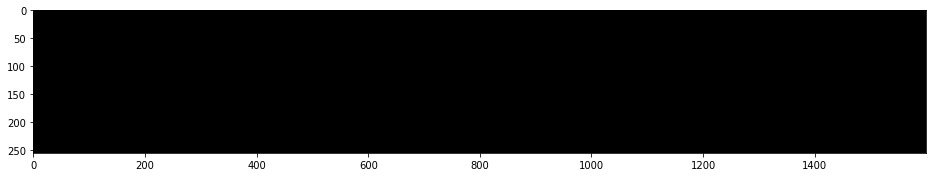

207f33325 4 TEST 382460


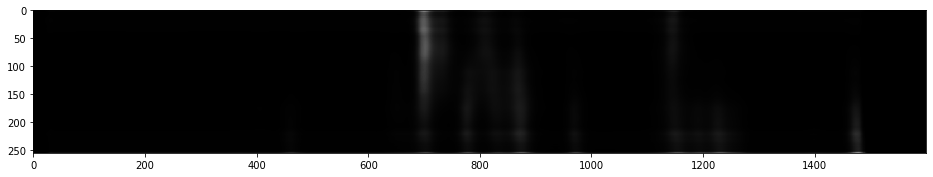

1ef276277


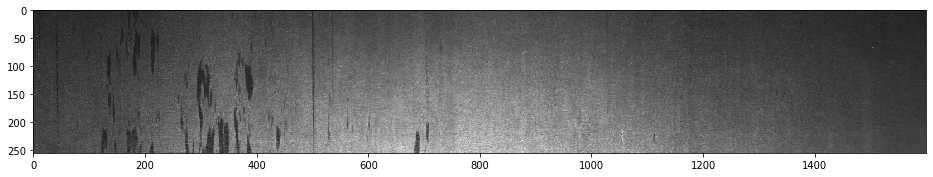

1ef276277 1 REF


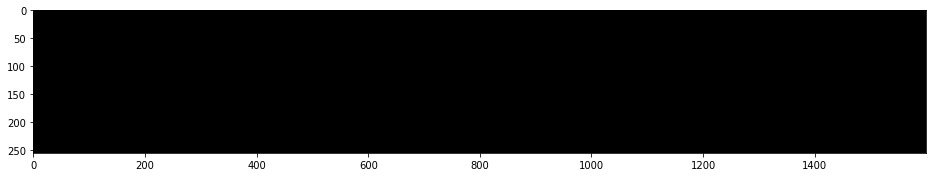

1ef276277 1 TEST 407794


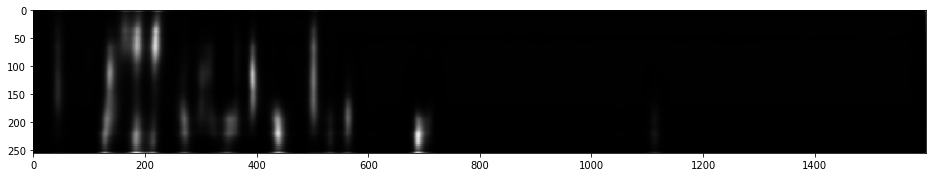

1ef276277 2 REF


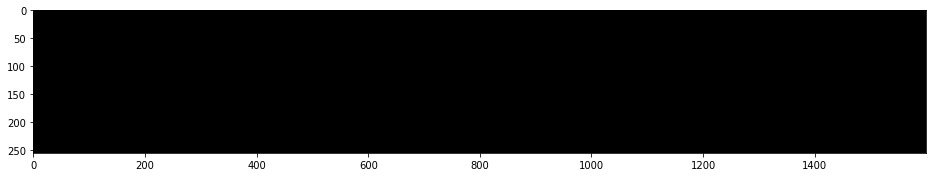

1ef276277 2 TEST 402838


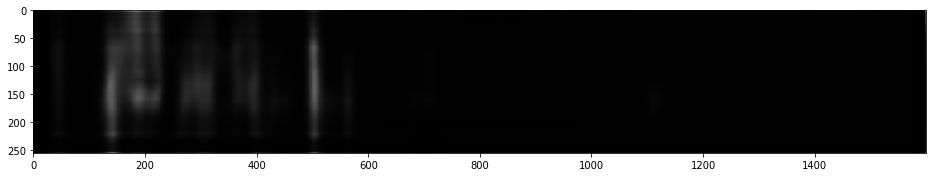

1ef276277 3 REF


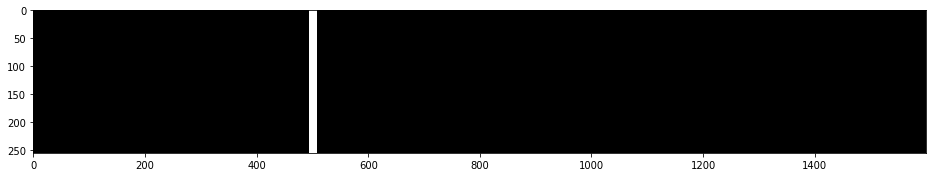

1ef276277 3 TEST 409600


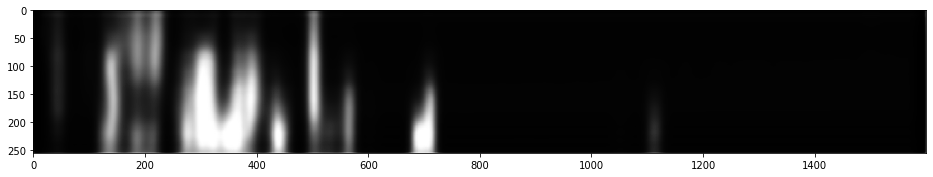

1ef276277 4 REF


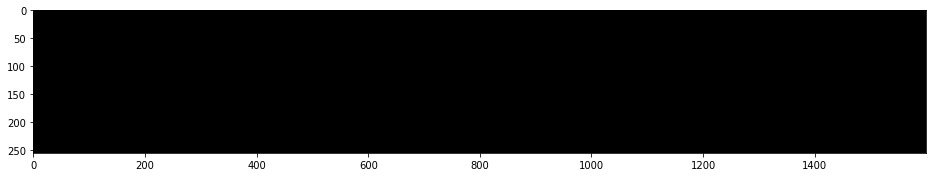

1ef276277 4 TEST 409600


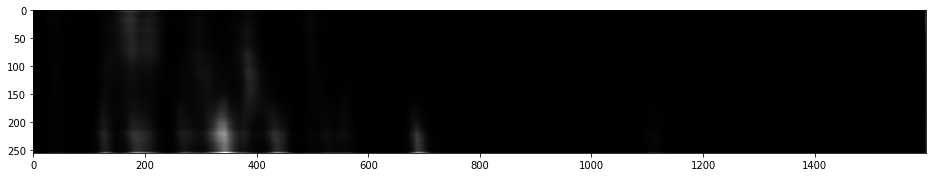

In [240]:
for i, name in enumerate(names):
    im = plt.imread(pth.join(TRAIN_IMG_DIR, f'{name}.jpg')).astype('float32')
    im /= 255
    
    print(name)
    plt.figure(figsize=(16, 3))
    plt.imshow(im, cmap='gray')
    plt.show()
    
    for j in [1, 2, 3, 4]:
        rows = data[(data.imageid == name) & (data.classid == j)]
        row = rows.iloc[0, :]

        if row.mask_present:
            mask_ref = image_masks[f'{name}_{j}']
        else:
            mask_ref = np.zeros((HEIGHT, WIDTH), dtype='uint8')
            
        print(name, j, 'REF')
        plt.figure(figsize=(16, 3))
        plt.imshow(mask_ref, cmap='gray')
        plt.show()
        
        mask_test = results[j - 1][i].squeeze()
        #mask_test = (mask_test > 0.5).astype('uint8')
        
        
        print(name, j, 'TEST', np.sum(mask_ref != mask_test))
        plt.figure(figsize=(16, 3))
        plt.imshow(mask_test, cmap='gray')
        plt.show()
